# Shape analysis

This notebook shows how to perform shape analysis using [GEMDAT](https://gemdat.readthedocs.org). 

This uses a generalized algorithm that for all symmetrically equivalent cluster centers, finds nearest atoms from trajectory, and transforms them back to the asymmetric unit. This helps the statistics for performing shape analysis and making plots.

As input you will need:

1. [symmetrized crystal or material structure](https://pymatgen.org/pymatgen.symmetry.html#pymatgen.symmetry.structure.SymmetrizedStructure)
    - contains unique sites to act as cluster centers (asymmetic unit)
    - provides symmetry operations
    - Gemdat uses [SpacegroupAnalyzer](https://pymatgen.org/pymatgen.symmetry.html#pymatgen.symmetry.analyzer.SpacegroupAnalyzer) to find symmetry in P1 structures
2. [trajectory](https://pymatgen.org/pymatgen.symmetry.html#pymatgen.symmetry.analyzer.SpacegroupAnalyzer)
    - typically P1
    - maybe a supercell of the structure in #1
    - lattice can be triclinic (non-constrained in simulation)

The `ShapeAnalyzer` algorithm works as follows:

1. reduce supercell of trajectory to match clusters
    - assert trajectory and cluster lattices are similar
2. for every unique center:
    - for every symmetry operation:
        - apply symmetry operation to center coordinates
        - find all trajectory points within X distance of transformed coordinates (wrap around pbc)
        - copy and map points back to asymmetric unit (reverse symmetry op)
        - subtract center coords
    - concatenate all coords and convert to Cartesian coordinate system

The result is a set of trajectory positions centered on the input sites. These can be used to perform shape analysis: plots, fits, heat maps, msd, etc.

See: https://github.com/GEMDAT-repos/GEMDAT/pull/166

In [1]:
%load_ext autoreload
%autoreload 2

## Loading data

Loading trajectory for argyrodite and cif file with 3 unique sites as cluster centers.

In [2]:
from pathlib import Path

from gemdat import Trajectory
from gemdat.io import read_cif

workdir = Path('/home/stef/md-analysis-matlab-example-short/shape_analysis')

trajectory = Trajectory.from_vasprun(workdir / 'vasprun.xml')
diff_trajectory = trajectory.filter('Li')

structure = read_cif(workdir / 'argyrodite_48h48h16e.cif')

/home/stef/python/gemdat/.venv/lib64/python3.12/site-packages/MDAnalysis/topology/TPRParser.py:161: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  import xdrlib


## Set up shape analyzer

Note that the we use the `.from_structure` constructor. This symmetrizes the input structure.

In [3]:
from gemdat.shape import ShapeAnalyzer

sa = ShapeAnalyzer.from_structure(structure)
sa

ShapeAnalyzer
    Spacegroup
        F-43m (216)
    Lattice
        abc   :   9.924000   9.924000   9.924000
        angles:  90.000000  90.000000  90.000000
    Unique sites (3)
        PeriodicSite: 48h (Li) (1.816, 1.816, 0.2382) [0.183, 0.183, 0.024]
        PeriodicSite: 48h2 (Li) (0.7939, 0.7939, 1.816) [0.08, 0.08, 0.183]
        PeriodicSite: 16e (Li) (8.535, 8.535, 8.535) [0.86, 0.86, 0.86]

## Clustering

The next cell shows how to run the shape analysis. The radius in Ångström is used to determine if an atom belongs to a cluster.

The supercell is used to fold the trajectory coordinates to the same lattice as the input sites. A warning will be raised if the lattices are not close.

Alternatively, you can pass any numpy array with fractional coordinates to `sa.analyze_positions()`

In [4]:
supercell = (2, 1, 1)
radius = 1.0  # Å

shapes = sa.analyze_trajectory(
    trajectory=diff_trajectory,
    supercell=supercell,
    radius=radius,
)

shapes[0]

ShapeData(name='48h', coords=array([[-0.11849693, -0.18059447, -0.13624759],
       [-0.11854397, -0.18051359, -0.13607154],
       [-0.12119189, -0.17594845, -0.12613722],
       ...,
       [-0.30739114,  0.20197166,  0.14155514],
       [-0.30049991,  0.21544538,  0.17277396],
       [-0.29367061,  0.22773278,  0.20439887]]), radius=1.0)

## Plot shapes

Shape data can be plotted using the `plots` module. This shows each set of shape coordinates from all three directions.

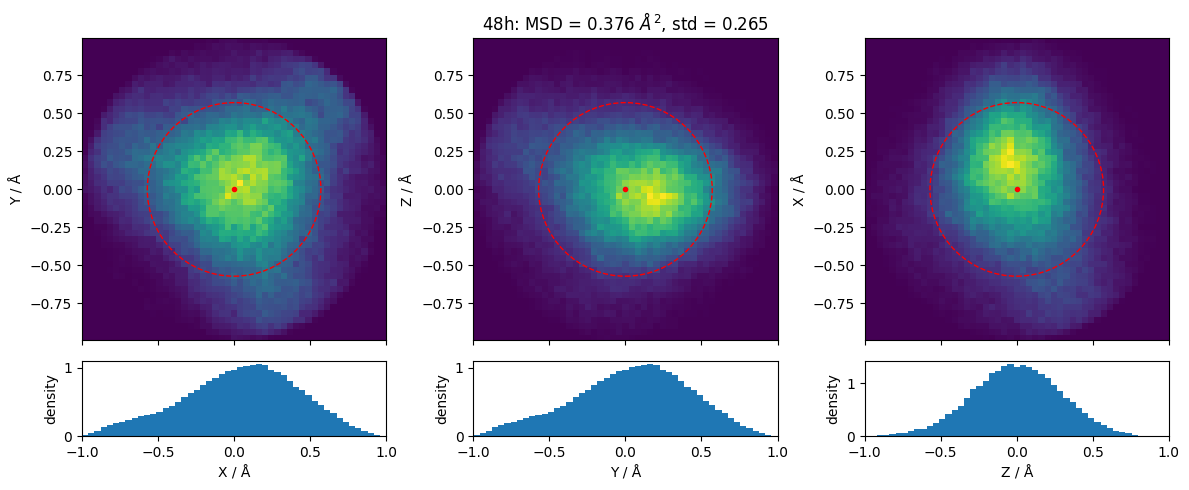

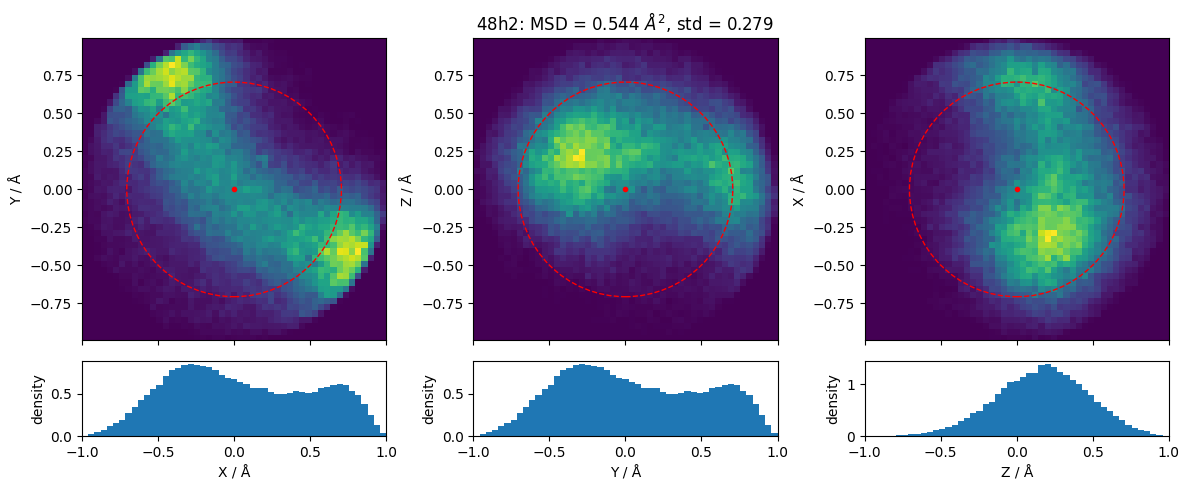

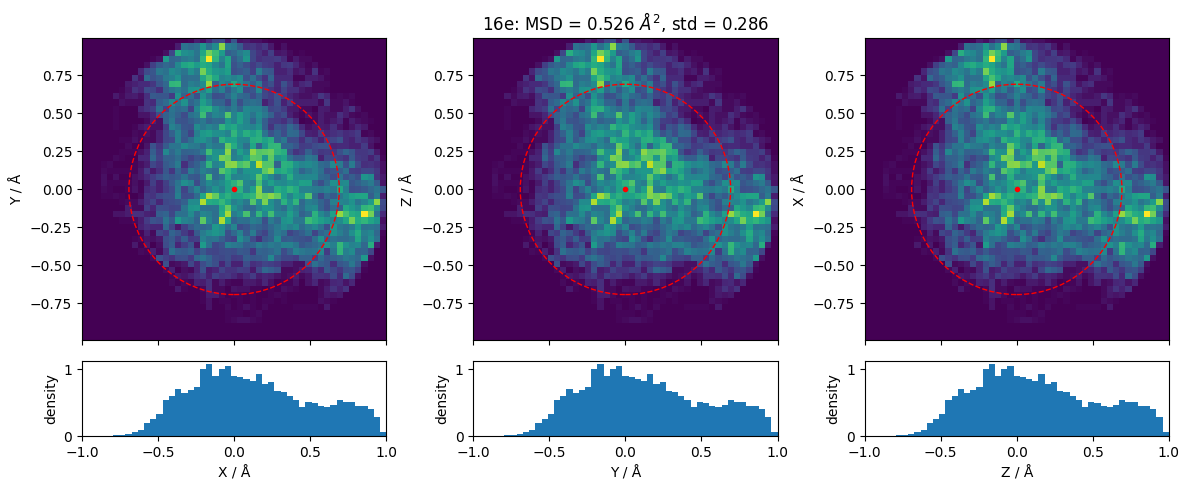

In [5]:
import matplotlib.pyplot as plt
import numpy as np

from gemdat import plots

bins = np.linspace(-radius, radius, 50)

for shape in shapes:
    plots.shape(shape, bins=bins)
    plt.show()

## Optimize sites

You can optimize the site positions using the `ShapeAnalyzer.optimize_sites()` method. This uses the centroid of the shapes to shift the sites. Note that the sites ar

In [6]:
sa_shifted = sa.optimize_sites(shapes=shapes)
sa_shifted

ShapeAnalyzer
    Spacegroup
        F-43m (216)
    Lattice
        abc   :   9.924000   9.924000   9.924000
        angles:  90.000000  90.000000  90.000000
    Unique sites (3)
        PeriodicSite: 48h (Li) (1.856, 1.856, 0.2354) [0.187, 0.187, 0.02372]
        PeriodicSite: 48h2 (Li) (0.8451, 0.8451, 1.98) [0.08516, 0.08516, 0.1995]
        PeriodicSite: 16e (Li) (8.665, 8.665, 8.665) [0.8732, 0.8732, 0.8732]

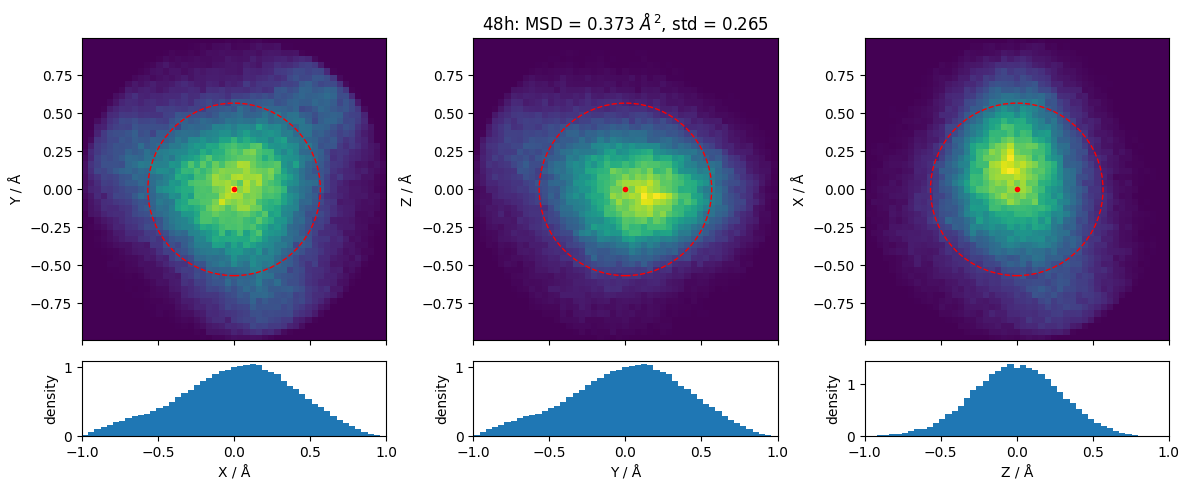

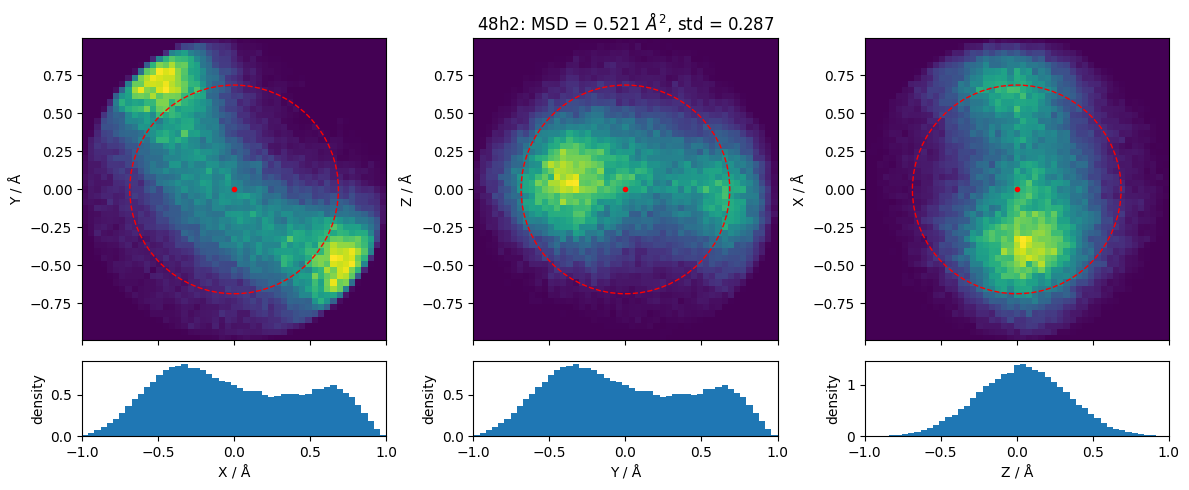

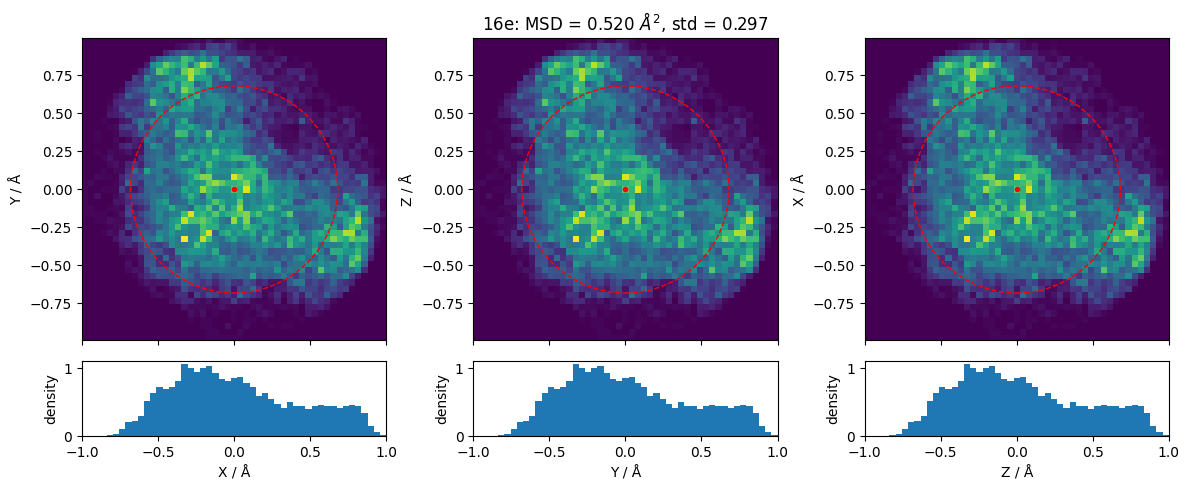

In [7]:
shapes = sa_shifted.analyze_trajectory(
    trajectory=diff_trajectory,
    supercell=supercell,
    radius=radius,
)

for shape in shapes:
    plots.shape(shape, bins=bins)
    plt.show()

## Custom shifts

You can also use your own vectors to shift the sites:

In [8]:
vectors = (
    [1,0,0],
    [2,0,0],
    [3,0,0],    
)

sa_shifted = sa.shift_sites(vectors=vectors)
sa_shifted

ShapeAnalyzer
    Spacegroup
        F-43m (216)
    Lattice
        abc   :   9.924000   9.924000   9.924000
        angles:  90.000000  90.000000  90.000000
    Unique sites (3)
        PeriodicSite: 48h (Li) (2.816, 1.816, 0.2382) [0.2838, 0.183, 0.024]
        PeriodicSite: 48h2 (Li) (2.794, 0.7939, 1.816) [0.2815, 0.08, 0.183]
        PeriodicSite: 16e (Li) (11.53, 8.535, 8.535) [1.162, 0.86, 0.86]

## Get structure

Use `ShapeAnalyzer.get_structure()` to retrieve a pymatgen `Structure` object back:

In [9]:
sa_shifted = sa_shifted.to_structure()
sa_shifted

Structure Summary
Lattice
    abc : 9.924 9.924 9.924
 angles : 90.0 90.0 90.0
 volume : 977.3728410239999
      A : 9.924 0.0 6.076697417369166e-16
      B : 1.5959009175390938e-15 9.924 6.076697417369166e-16
      C : 0.0 0.0 9.924
    pbc : True True True
PeriodicSite: 48h (Li) (7.108, 5.2, 3.146) [0.7162, 0.524, 0.317]
PeriodicSite: 48h (Li) (0.2382, 2.146, 3.146) [0.024, 0.2162, 0.317]
PeriodicSite: 48h (Li) (7.108, 4.724, 6.778) [0.7162, 0.476, 0.683]
PeriodicSite: 48h (Li) (9.686, 7.778, 3.146) [0.976, 0.7838, 0.317]
PeriodicSite: 48h (Li) (2.816, 5.2, 6.778) [0.2838, 0.524, 0.683]
PeriodicSite: 48h (Li) (1.816, 5.2, 7.778) [0.183, 0.524, 0.7838]
PeriodicSite: 48h (Li) (1.816, 4.724, 2.146) [0.183, 0.476, 0.2162]
PeriodicSite: 48h (Li) (9.686, 7.108, 1.816) [0.976, 0.7162, 0.183]
PeriodicSite: 48h (Li) (7.108, 0.2382, 8.108) [0.7162, 0.024, 0.817]
PeriodicSite: 48h (Li) (0.2382, 7.108, 8.108) [0.024, 0.7162, 0.817]
PeriodicSite: 48h (Li) (8.108, 2.816, 9.686) [0.817, 0.2838, 0.9